In [1]:
from omega.dataBase import EOD
import matplotlib.pyplot as plt
import numpy as np
import random

%matplotlib inline

/home/xnie/.anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
rb888 = EOD("rb888", "15min")

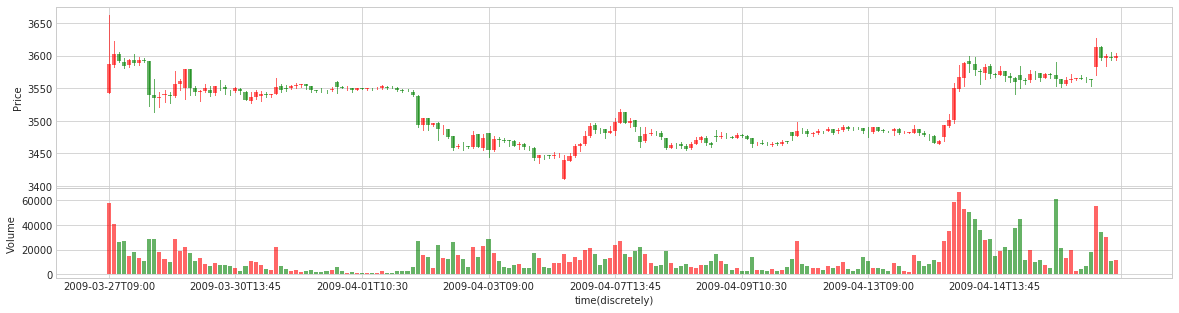

(<matplotlib.axes._subplots.AxesSubplot at 0x7fbf70e41a20>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fbf6dd2fe80>)

In [3]:
rb888[:200, :].plot()

In [4]:
rb888.open.shape

(40534,)

In [5]:
def dist_ed(x1, y1, x3, y3, x2, y2):
    return np.sqrt(np.power(x2-x1, 2)+np.power(y2-y1, 2)) + np.sqrt(np.power(x3-x2, 2)+np.power(y3-y2, 2))
def dist_pd(x1, y1, x3, y3, x2, y2):
    "x3 should never be the same as x1"
    s = (y3-y1) / (x3-x1)
    xc = (x2 + s*y2 + s**2*x3-s*y3) / (1+s**2)
    yc = s*xc - s*x3+y3
    return np.sqrt(np.power(xc-x2, 2)+np.power(yc-y2, 2))
def dist_vd(x1, y1, x3, y3, x2, y2):
    "x3 should never be the same as x1"
    s = (y3-y1) / (x3-x1)
    return np.abs(y1+(x2-x1)*s-y2)

def filter_pip(xarr, yarr, k=3):
    if xarr.shape != yarr.shape or xarr.shape[0] <= k:
        raise ValueError("xarr should have the same length as yarr")
        
    num = xarr.shape[0]
    out = [0, num-1]
    
    while len(out) < k:
        wgts = np.zeros(num)
        for sidx, eidx in zip(out[:-1], out[1:]):
            if sidx+1 == eidx:
                continue
            ed = dist_ed(xarr[sidx], yarr[sidx], xarr[eidx], yarr[eidx], xarr[sidx+1:eidx], yarr[sidx+1:eidx])
            pd = dist_pd(xarr[sidx], yarr[sidx], xarr[eidx], yarr[eidx], xarr[sidx+1:eidx], yarr[sidx+1:eidx])
            vd = dist_vd(xarr[sidx], yarr[sidx], xarr[eidx], yarr[eidx], xarr[sidx+1:eidx], yarr[sidx+1:eidx])
            wgts[sidx+1:eidx] = np.max([ed, pd, vd], axis=0)
            
        next_id = np.argmax(wgts)
        
        if next_id in out:
            print("Should not happen in common data")
            next_id = 0
            while next_id in out:
                next_id = np.random.randint(0, num)

        out.append(next_id)
        out.sort()
    
    return np.array(out)

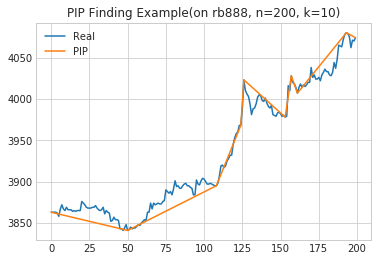

In [6]:
num = 1000
xarr = np.arange(200)
yarr = rb888.open[num:num+200]

out = filter_pip(xarr, yarr, 10)

plt.plot(xarr, yarr, label="Real")
plt.plot(xarr[out], yarr[out], label="PIP")
plt.title("PIP Finding Example(on rb888, n=200, k=10)")
plt.legend()
# plt.savefig("pip examples.jpg")

In [7]:
def data_iter(data, train_window = 500, predict_window = 500):
    
    num = data.info.maxlen
    indices = list(range(train_window, num-predict_window))
    random.shuffle(indices)
    
    for i in indices:
        train = data[i-train_window:i]
        predict = data[i-train_window:i+predict_window]
        yield train, predict

## DTW/PLA Method

In [8]:
from strategy import MACD, ATR

In [19]:
train_window = 500
predict_window = 500
data = EOD("ru888", "15min")

# sig = MACD()
sig = ATR()
sig.max_cached = train_window

features_width = int(0.05*train_window)
features_height = 1000

features_X = np.zeros((features_height, features_width))
features_Y = np.zeros((features_height, features_width))
labels = np.zeros(features_height)
for i, (t, p) in enumerate(data_iter(data, train_window, predict_window)):
    if i >= features_height:
        break
        
    re = sig._on(p)
    xarr = np.arange(train_window)
    yarr = t.close
    labels[i] = re.indicators["summary"]["sharpe_ratio_net"]
    indices = filter_pip(xarr, yarr, features_width)
    features_X[i, :] = xarr[indices]
    features_Y[i, :] = yarr[indices]

    if i % 100 == 0:
        print("current @", t.info.start, labels[i])

current @ 2008-09-05T10:00 0.4223287336858436
current @ 2013-06-19T10:45 -2.6976170111451094
current @ 2012-04-09T09:15 -2.5726401028643924
current @ 2016-10-10T21:45 -1.716714924725155
current @ 2017-08-02T11:00 6.176810720206686
current @ 2009-09-01T14:00 -4.69978099287141
current @ 2014-08-11T09:00 -0.3708009295751337
current @ 2014-12-18T14:00 3.58732904663553
current @ 2016-08-23T14:00 3.6275250145127655
current @ 2011-06-30T11:00 -0.8014013584433761


### PLA

In [20]:
def calculate_pla(obj, dis_arr):
    "obj is nx1, dis_arr is mxn"
    out = dis_arr - obj
    return np.sum(out**2, axis=1)

predict = np.zeros(features_height)
for i in range(features_height):
    obj = features_Y[i, :]
    dis = np.delete(features_Y, i, axis=0)
    la = labels[i]
    las = np.delete(labels, i)
    
    wgts = 1 / calculate_pla(obj, dis)
    wgts = wgts / wgts.sum()
    predict[i] = np.sum(wgts * las)

    if i % 100 == 0:
        print("finished @", i, "with wgts:", wgts.shape, "?is normalize:", wgts.sum())

finished @ 0 with wgts: (999,) ?is normalize: 1.0000000000000002
finished @ 100 with wgts: (999,) ?is normalize: 0.9999999999999997
finished @ 200 with wgts: (999,) ?is normalize: 1.0000000000000002
finished @ 300 with wgts: (999,) ?is normalize: 0.9999999999999999
finished @ 400 with wgts: (999,) ?is normalize: 1.0
finished @ 500 with wgts: (999,) ?is normalize: 1.0
finished @ 600 with wgts: (999,) ?is normalize: 0.9999999999999999
finished @ 700 with wgts: (999,) ?is normalize: 1.0
finished @ 800 with wgts: (999,) ?is normalize: 1.0
finished @ 900 with wgts: (999,) ?is normalize: 1.0


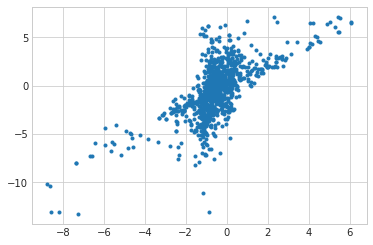

In [21]:
plt.plot(predict, labels, '.')

### DTW

In [22]:
from fastdtw import fastdtw

In [23]:
def calculate_dtw(obj, dis_arr):
    "obj is nx1, dis_arr is mxn"
    out = np.zeros(dis_arr.shape[0])
    
    for i in range(out.shape[0]):
        # print(obj, dis_arr[i, :, :])
        distance, _ = fastdtw(obj, dis_arr[i, :, :])
        out[i] = distance
    
    return out

predict = np.zeros(features_height)
for i in range(features_height):
    obj_Y = features_Y[i, :]
    obj_X = features_X[i, :]
    obj = np.column_stack((obj_X, obj_Y))
    
    dis_X = np.delete(features_X, i, axis=0)
    dis_Y = np.delete(features_Y, i, axis=0)
    dis = np.stack((dis_X, dis_Y), axis=2)
    la = labels[i]
    las = np.delete(labels, i)
    
    wgts = 1 / calculate_dtw(obj, dis)
    wgts = wgts / wgts.sum()
    predict[i] = np.sum(wgts * las)
    if i % 100 == 0:
        print("finished @", i, "with wgts:", wgts.shape, "?is normalize:", wgts.sum())

/home/xnie/.anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  import sys


finished @ 0 with wgts: (999,) ?is normalize: 0.9999999999999999
finished @ 100 with wgts: (999,) ?is normalize: 0.9999999999999999
finished @ 200 with wgts: (999,) ?is normalize: 1.0000000000000002
finished @ 300 with wgts: (999,) ?is normalize: 0.9999999999999998
finished @ 400 with wgts: (999,) ?is normalize: 0.9999999999999999
finished @ 500 with wgts: (999,) ?is normalize: 1.0
finished @ 600 with wgts: (999,) ?is normalize: 1.0
finished @ 700 with wgts: (999,) ?is normalize: 1.0
finished @ 800 with wgts: (999,) ?is normalize: 1.0
finished @ 900 with wgts: (999,) ?is normalize: 1.0


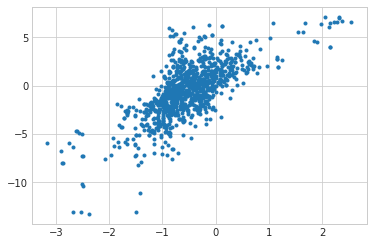

In [24]:
plt.plot(predict, labels, '.')

## OLS Method

In [56]:
rb888.shape

(40534, 6, 1)